# Groundwater quality

#### This notebook performs exploratory data analysis (EDA) on groundwater well data from several Dutch provinces, specdifically, Zeeland, Utrecht, Flevoland, and North Holland. It visualizes chemical measurements such as nitrate and chloride over time, identifies missing values, and maps well locations on a basemap of the Netherlands.

In [30]:
import pandas as pd
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely import wkt
import contextily as ctx
from IPython.display import Image, display
import seaborn as sns
from matplotlib.colors import ListedColormap

In [19]:
def plot_well(df_filtered, well, filter_number, variable_to_plot):
    df_well = df_filtered[df_filtered["Well_ID"] == well].sort_values("Date")
    plt.figure(figsize=(10, 4))
    plt.plot(df_well["Date"], df_well[variable_to_plot], marker='o')
    plt.title(f"{variable_to_plot} Levels - Well {well} - Filter {filter_number}")
    plt.xlabel("Date")
    plt.ylabel(f"{variable_to_plot} (mg/L)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_filter(df, filter_number, variable_to_plot, num_wells=10):
    #check number of data points
    df_filtered = df[df["Filter"] == filter_number]
    print(f"Number of data points at filter {filter_number}: {len(df_filtered)}")

    missing_nitrate = df_filtered[df_filtered["Nitrate"].isna()] #check for Nan
    print("Missing Nitrate:", len(missing_nitrate))

    missing_chloride = df_filtered[df_filtered["Chloride"].isna()] #check for Nan
    print("Missing Chloride:", len(missing_chloride))
    print("\n")
    
    # plot first n wells
    # if num_wells:
    #     wells = df_filtered["Well_ID"].unique()[:num_wells]
    #     for well in wells:
    #         plot_well(df_filtered, well, filter_number, variable_to_plot)
    #     print("\n")

    if num_wells:
        # Rank wells by how many non-NaN values they have for the selected variable
        # Find the well with the most non-NaN values for the selected variable
        top_well = (
            df_filtered.groupby("Well_ID")[variable_to_plot]
            .apply(lambda x: x.notna().sum())
            .sort_values(ascending=False)
            .index[0]
        )
        plot_well(df_filtered, top_well, filter_number, variable_to_plot)
        return top_well

def filter_histogram(df, province, n_filters):
    filters = list(range(0, n_filters))
    total_counts = []
    missing_nitrate_counts = []
    missing_chloride_counts = []

    for f in filters:
        df_filt = df[df["Filter"] == f]
        total_counts.append(len(df_filt))
        missing_nitrate_counts.append(df_filt["Nitrate"].isna().sum())
        missing_chloride_counts.append(df_filt["Chloride"].isna().sum())

    x = np.arange(len(filters))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, total_counts, width=width, label="Total", color="#f0a83c")
    plt.bar(x, missing_nitrate_counts, width=width, label="Missing Nitrate", color="#e2713c")
    plt.bar(x + width, missing_chloride_counts, width=width, label="Missing Chloride", color="#e24956")

    plt.xlabel("Filter")
    plt.ylabel("Number of Data Points")
    plt.title(f"{province.capitalize()} - Data Points per Filter")
    plt.xticks(x, filters)
    plt.legend()
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

def well_location_finder(df, highlighted_wells=None):

    df['geometry'] = df['geometry'].apply(wkt.loads) #geometry strings to shapely Point objects
    gdf = gpd.GeoDataFrame(df, geometry='geometry')   # convert to GeoDataFrame (will be done in acc pipeline soon!)

    #coordinate reference system (CRS) to WGS84 (standard GPS)
    gdf.set_crs(epsg=4326, inplace=True)
    gdf_web = gdf.to_crs(epsg=3857)

    # show on top of Netherlands basemap
    ax = gdf_web.plot(figsize=(10, 10), color="darkblue", alpha=0.6, markersize=30)

    if highlighted_wells:
        highlight = gdf_web[gdf_web['Well_ID'].isin(highlighted_wells)]
        highlight.plot(ax=ax, color="crimson", markersize=60, label="Selected Wells")

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()
    plt.title("Groundwater Wells in the Netherlands")
    plt.show()


def eda_pipeline(province, variable_to_plot, num_wells=10):
    current_dir = os.getcwd()
    #path = os.path.join(current_dir, f'../data/raw/well_chem_data/{province}_well_combined.csv')
    path = os.path.join(current_dir, f'../data/raw/well_chem_data/{province}_well_chem_combined.csv')
    df = pd.read_csv(path)

    # parse datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

    # sort by date
    df = df.sort_values(by=['Well_ID', 'Date'])

    #total number of data points
    total = len(df)
    print("Number of data points:", total)

    # total nitrate missing
    missing_nitrate = df[df['Nitrate'].isna()]
    print("\nNumber of rows with missing Nitrate:\n", len(missing_nitrate))

    # total chloride missing
    missing_chloride = df[df['Chloride'].isna()]
    print("\nNumber of rows with missing Chloride:\n", len(missing_chloride))
    print("\n")

    # count specific: Filter 1, after and including 2000, NO3_N present
    df['Year'] = df['Date'].dt.year
    filter1_nitrate_present = df[(df['Filter'] == 0) & (df['Year'] >= 2000) & (df['Nitrate'].notna())]
    count_filter1 = len(filter1_nitrate_present)
    print(f"Number of data points for Filter 0, after year 2000, no missing Nitrate: {count_filter1}\n")

    df['Year'] = df['Date'].dt.year
    filter1_nitrate_present = df[(df['Filter'] == 1) & (df['Year'] >= 2000) & (df['Nitrate'].notna())]
    count_filter1 = len(filter1_nitrate_present)
    print(f"Number of data points for Filter 1, after year 2000, no missing Nitrate: {count_filter1}\n")

    filter1_nitrate_present = df[(df['Filter'] == 2) & (df['Year'] >= 2000) & (df['Nitrate'].notna())]
    count_filter1 = len(filter1_nitrate_present)
    print(f"Number of data points for Filter 2, after year 2000, no missing Nitrate: {count_filter1}\n")

    filter1_nitrate_present = df[(df['Filter'] == 3) & (df['Year'] >= 2000) & (df['Nitrate'].notna())]
    count_filter1 = len(filter1_nitrate_present)
    print(f"Number of data points for Filter 3, after year 2000, no missing Nitrate: {count_filter1}\n")

    # now we check more specific stats, per each filter
    selected_wells = []
    n_filters = df["Filter"].nunique()
    for filter_number in range(1, n_filters+1):
        print(f"Filter: {filter_number}")
        top_well = analyze_filter(df, filter_number, variable_to_plot=variable_to_plot, num_wells=num_wells)
        if top_well:
            selected_wells.append(top_well)

    #summarize stats per well in histogram
    filter_histogram(df, province, n_filters)

    #locate wells on the map
    well_location_finder(df, highlighted_wells=selected_wells)


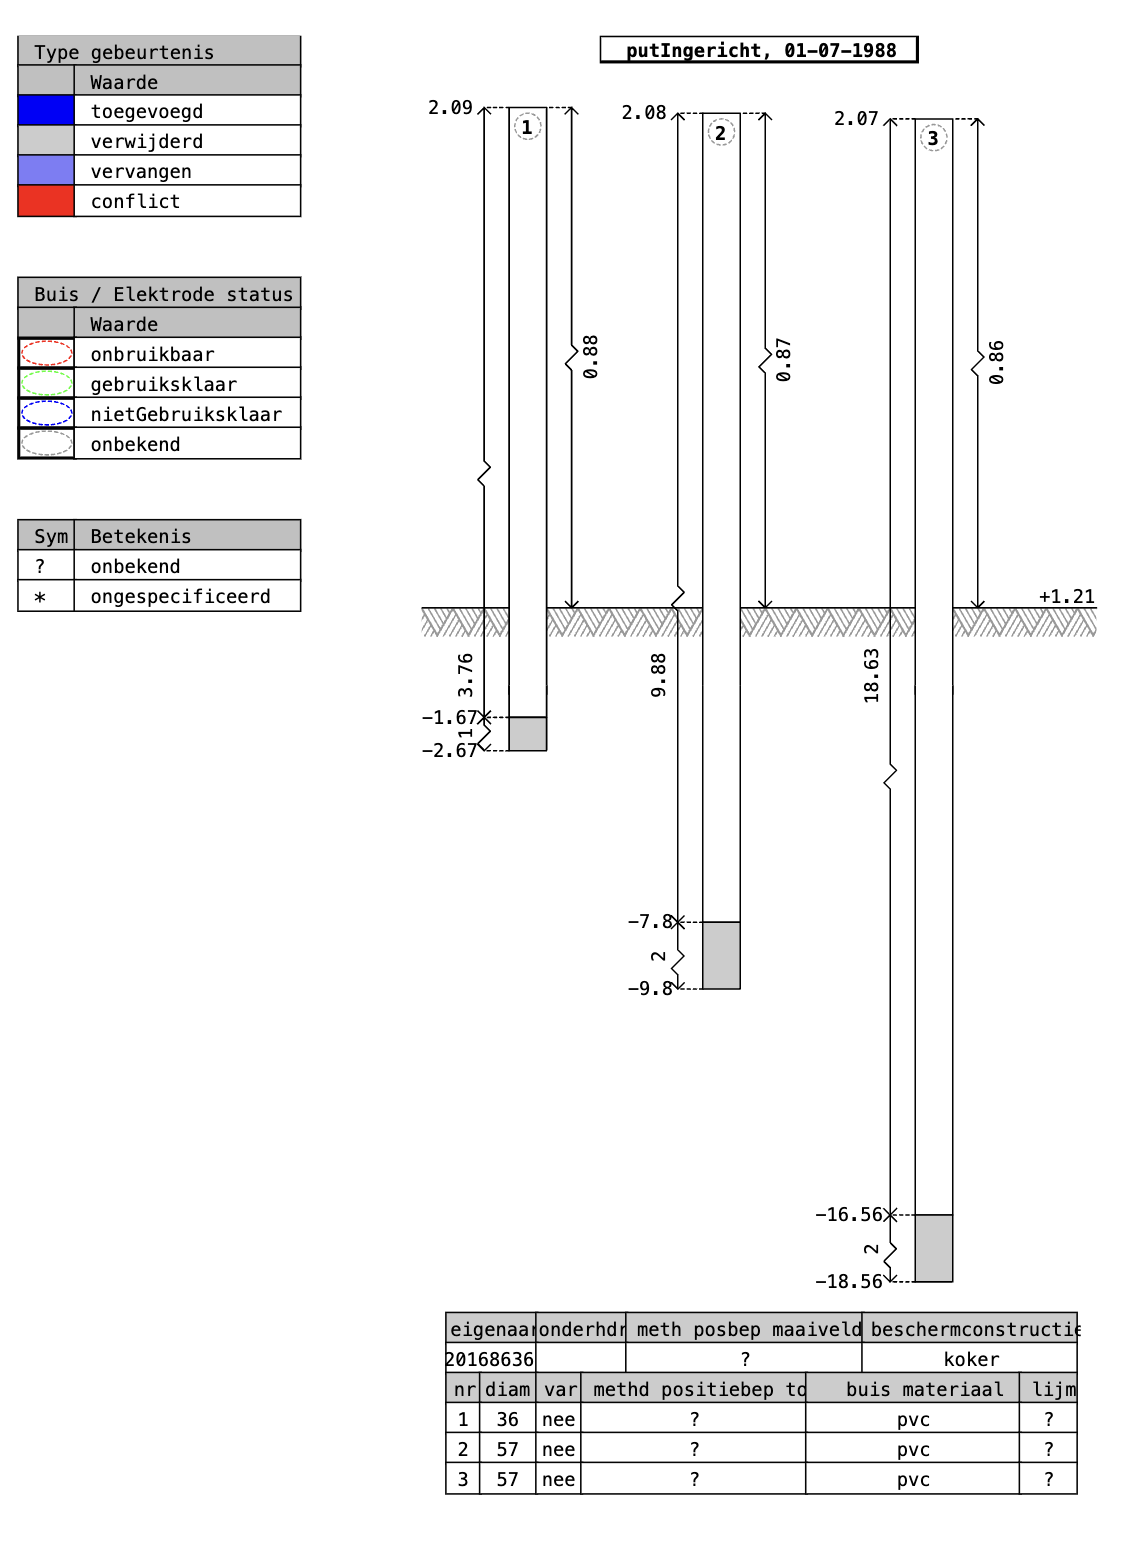

In [134]:
# depth of filters, only 3 filters, usually there are way more :)) up to 10
display(Image(filename="/Users/Administrator/Downloads/Pasted Graphic 5.png", width=600))

# Flevoland

Number of data points: 2311

Number of rows with missing Nitrate:
 435

Number of rows with missing Chloride:
 314


Number of data points for Filter 0, after year 2000, no missing Nitrate: 0

Number of data points for Filter 1, after year 2000, no missing Nitrate: 290

Number of data points for Filter 2, after year 2000, no missing Nitrate: 132

Number of data points for Filter 3, after year 2000, no missing Nitrate: 120

Filter: 1
Number of data points at filter 1: 954
Missing Nitrate: 165
Missing Chloride: 124


Filter: 2
Number of data points at filter 2: 611
Missing Nitrate: 192
Missing Chloride: 152


Filter: 3
Number of data points at filter 3: 547
Missing Nitrate: 57
Missing Chloride: 33


Filter: 4
Number of data points at filter 4: 104
Missing Nitrate: 12
Missing Chloride: 4


Filter: 5
Number of data points at filter 5: 43
Missing Nitrate: 8
Missing Chloride: 1


Filter: 6
Number of data points at filter 6: 30
Missing Nitrate: 1
Missing Chloride: 0


Filter: 7
Number of data

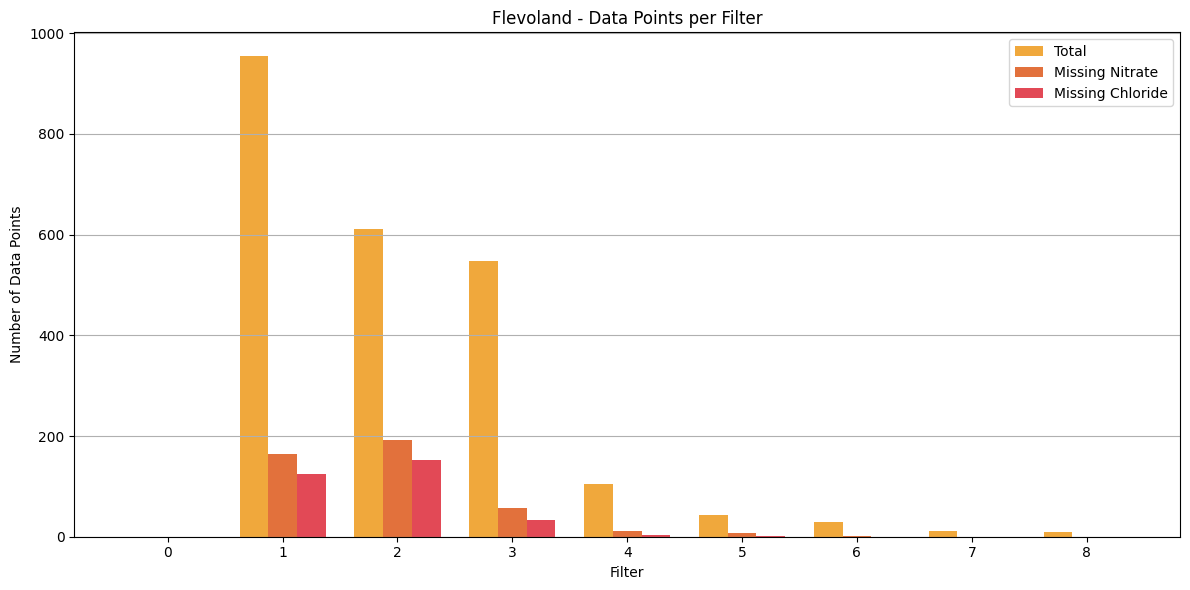

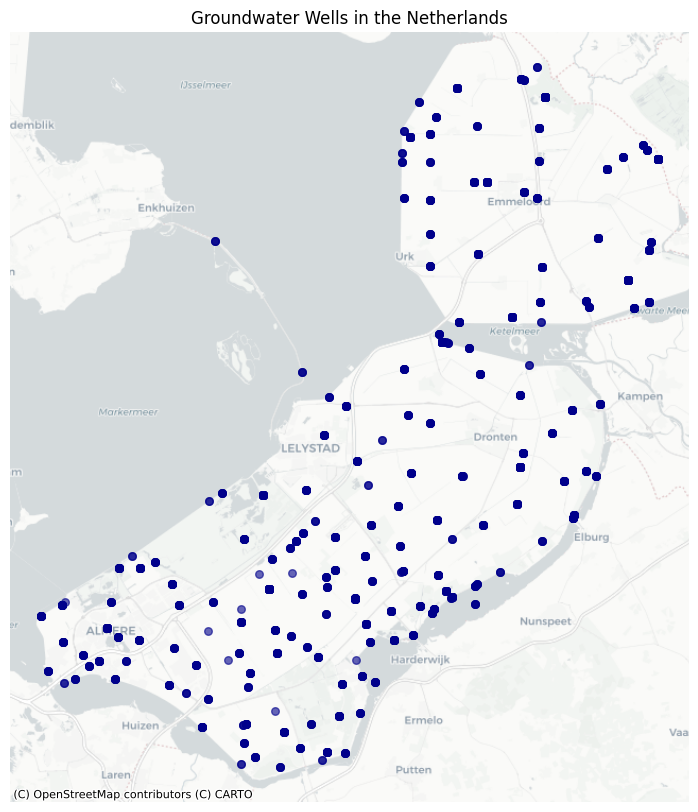

In [10]:
province = "flevoland"
variable_to_plot = "Nitrate"
num_wells = 0

eda_pipeline(province, variable_to_plot, num_wells)

# Utrecht

### Raw data

Number of data points: 1697

Number of rows with missing Nitrate:
 218

Number of rows with missing Chloride:
 218


Number of data points for Filter 0, after year 2000, no missing Nitrate: 0

Number of data points for Filter 1, after year 2000, no missing Nitrate: 551

Number of data points for Filter 2, after year 2000, no missing Nitrate: 181

Number of data points for Filter 3, after year 2000, no missing Nitrate: 171

Filter: 1
Number of data points at filter 1: 772
Missing Nitrate: 34
Missing Chloride: 33


Filter: 2
Number of data points at filter 2: 400
Missing Nitrate: 123
Missing Chloride: 124


Filter: 3
Number of data points at filter 3: 396
Missing Nitrate: 55
Missing Chloride: 55


Filter: 4
Number of data points at filter 4: 129
Missing Nitrate: 6
Missing Chloride: 6




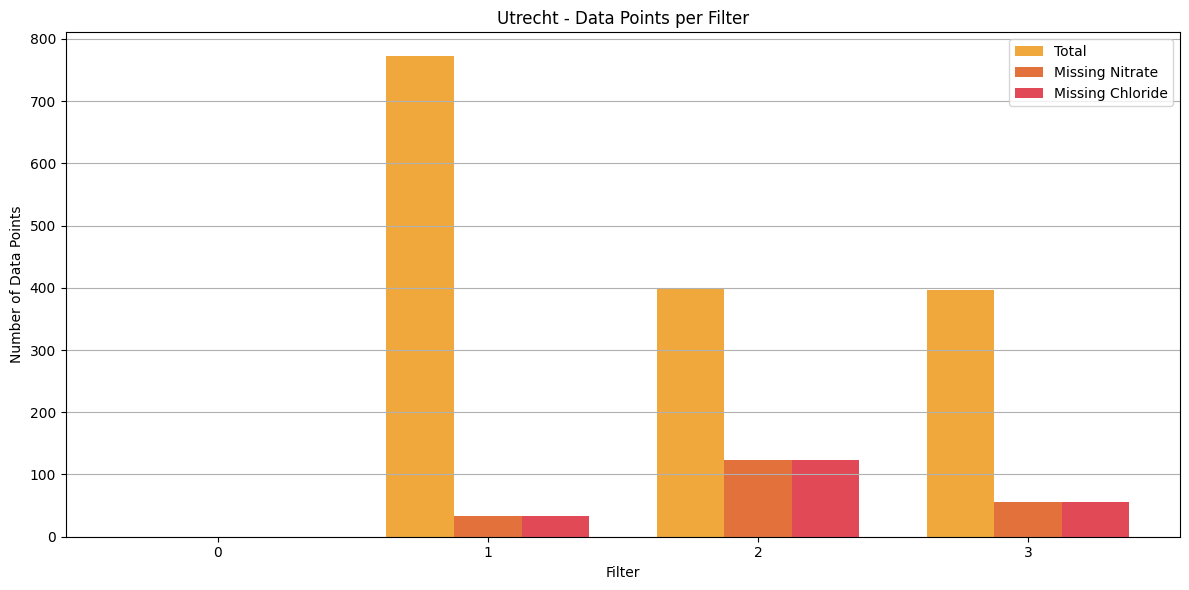

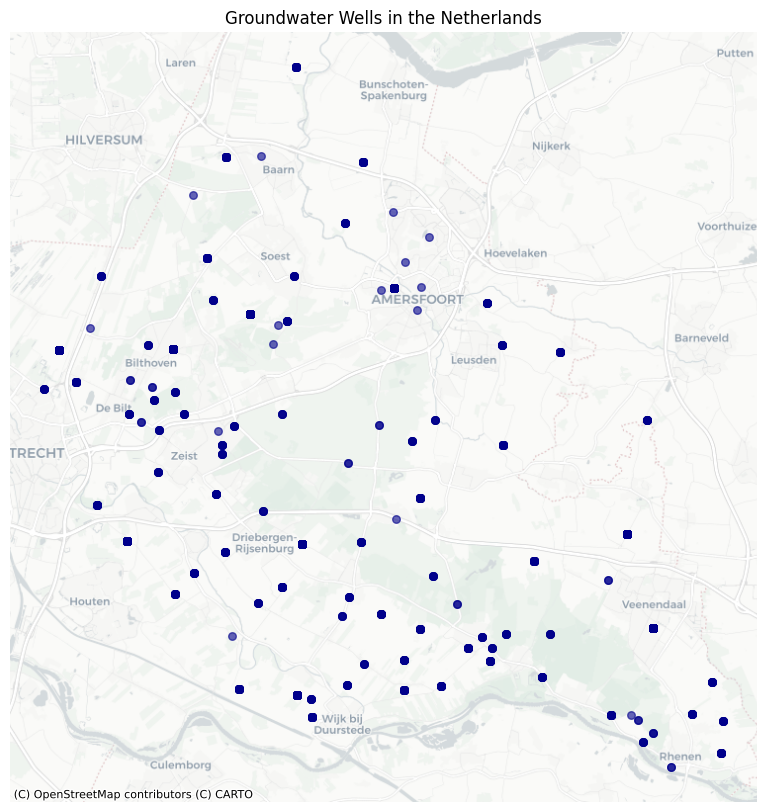

In [20]:
province = "utrecht"
variable_to_plot = "Nitrate"
num_wells = 0

eda_pipeline(province, variable_to_plot, num_wells)

### Preprocessed data

In [39]:
province = "utrecht"
variable = "chem"
filter = 3

current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
path = os.path.join(base_dir, f'data/clean/well_{variable}_data/{province}_well_{variable}_combined_{filter}.csv')

In [40]:
df_chem_3 = pd.read_csv(path)

In [41]:
print(f"Total number of data points in filter {filter}: {len(df_chem_3)}")

Total number of data points in filter 3: 171


In [45]:
# number of unique wells in dataset

wells_chem = set(df_chem_3['Well_ID'].dropna().unique())

unique_chem = df_chem_3['Well_ID'].nunique(dropna=False)

print(f"Unique Well-IDs in Nitrate dataset (including NaN): {unique_chem}")

Unique Well-IDs in Nitrate dataset (including NaN): 22


In [43]:
# Show the sampling frequences that are taking place in the dataset
df_chem_3['Date'] = pd.to_datetime(df_chem_3['Date'])

df = df_chem_3.sort_values(by=['Well_ID', 'Date']).reset_index(drop=True)

# Calculate time differences (sampling frequency) per well
df['Time_Diff'] = df.groupby('Well_ID')['Date'].diff()

# Show summary statistics of sampling frequency
sampling_freq_summary = df['Time_Diff'].describe()

# Show most common sampling intervals
common_intervals = df['Time_Diff'].value_counts()

with pd.option_context('display.max_rows', None):
    print(df['Time_Diff'].value_counts())  # Sorted by count descending

Time_Diff
365 days 00:00:00     12
381 days 00:00:00      8
903 days 23:00:00      4
35 days 23:00:00       3
514 days 00:00:00      3
520 days 00:00:00      3
1339 days 00:00:00     3
345 days 01:00:00      3
602 days 23:00:00      2
904 days 23:00:00      2
1077 days 23:00:00     2
826 days 01:00:00      2
548 days 00:00:00      2
456 days 01:00:00      2
609 days 23:00:00      2
168 days 01:00:00      2
518 days 00:00:00      2
167 days 01:00:00      2
462 days 01:00:00      2
1438 days 00:00:00     1
798 days 01:00:00      1
865 days 01:00:00      1
650 days 23:00:00      1
448 days 01:00:00      1
278 days 23:00:00      1
740 days 00:00:00      1
975 days 00:00:00      1
123 days 23:00:00      1
1090 days 23:00:00     1
547 days 00:00:00      1
652 days 23:00:00      1
812 days 01:00:00      1
671 days 23:00:00      1
402 days 01:00:00      1
1004 days 23:00:00     1
70 days 01:00:00       1
1202 days 00:00:00     1
582 days 23:00:00      1
825 days 00:00:00      1
617 days 23:00:

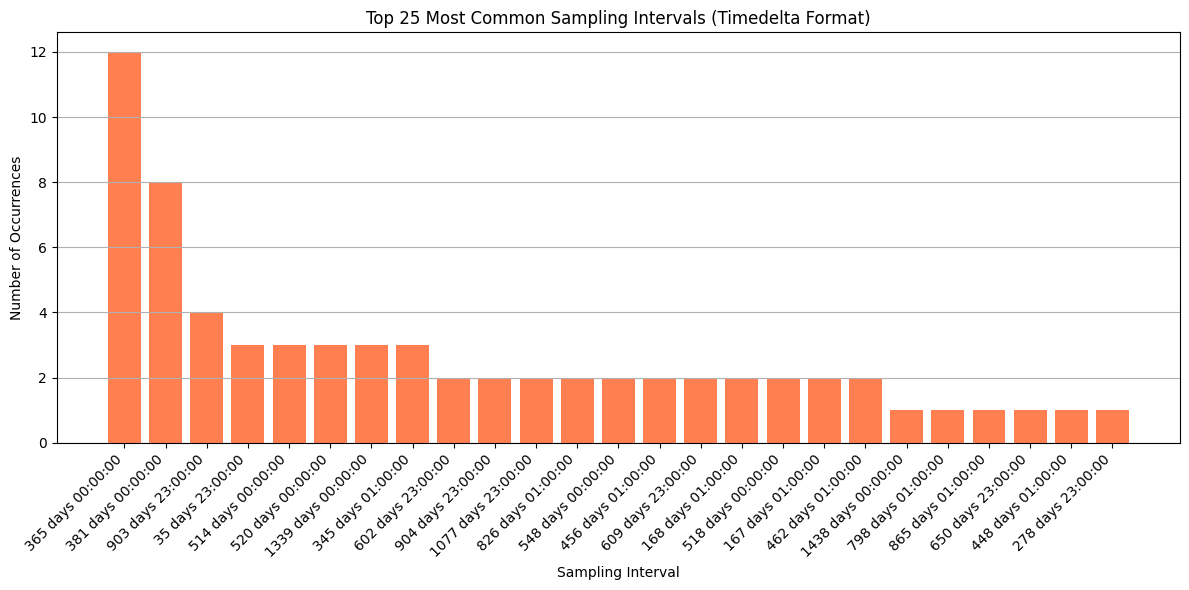

In [44]:
top_intervals = common_intervals.head(25)

labels = top_intervals.index.astype(str)

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_intervals)), top_intervals.values, color='coral')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.xlabel("Sampling Interval")
plt.ylabel("Number of Occurrences")
plt.title("Top 25 Most Common Sampling Intervals (Timedelta Format)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_70453/191183236.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot = pivot.applymap(lambda x: 1 if x > 0 else 0)


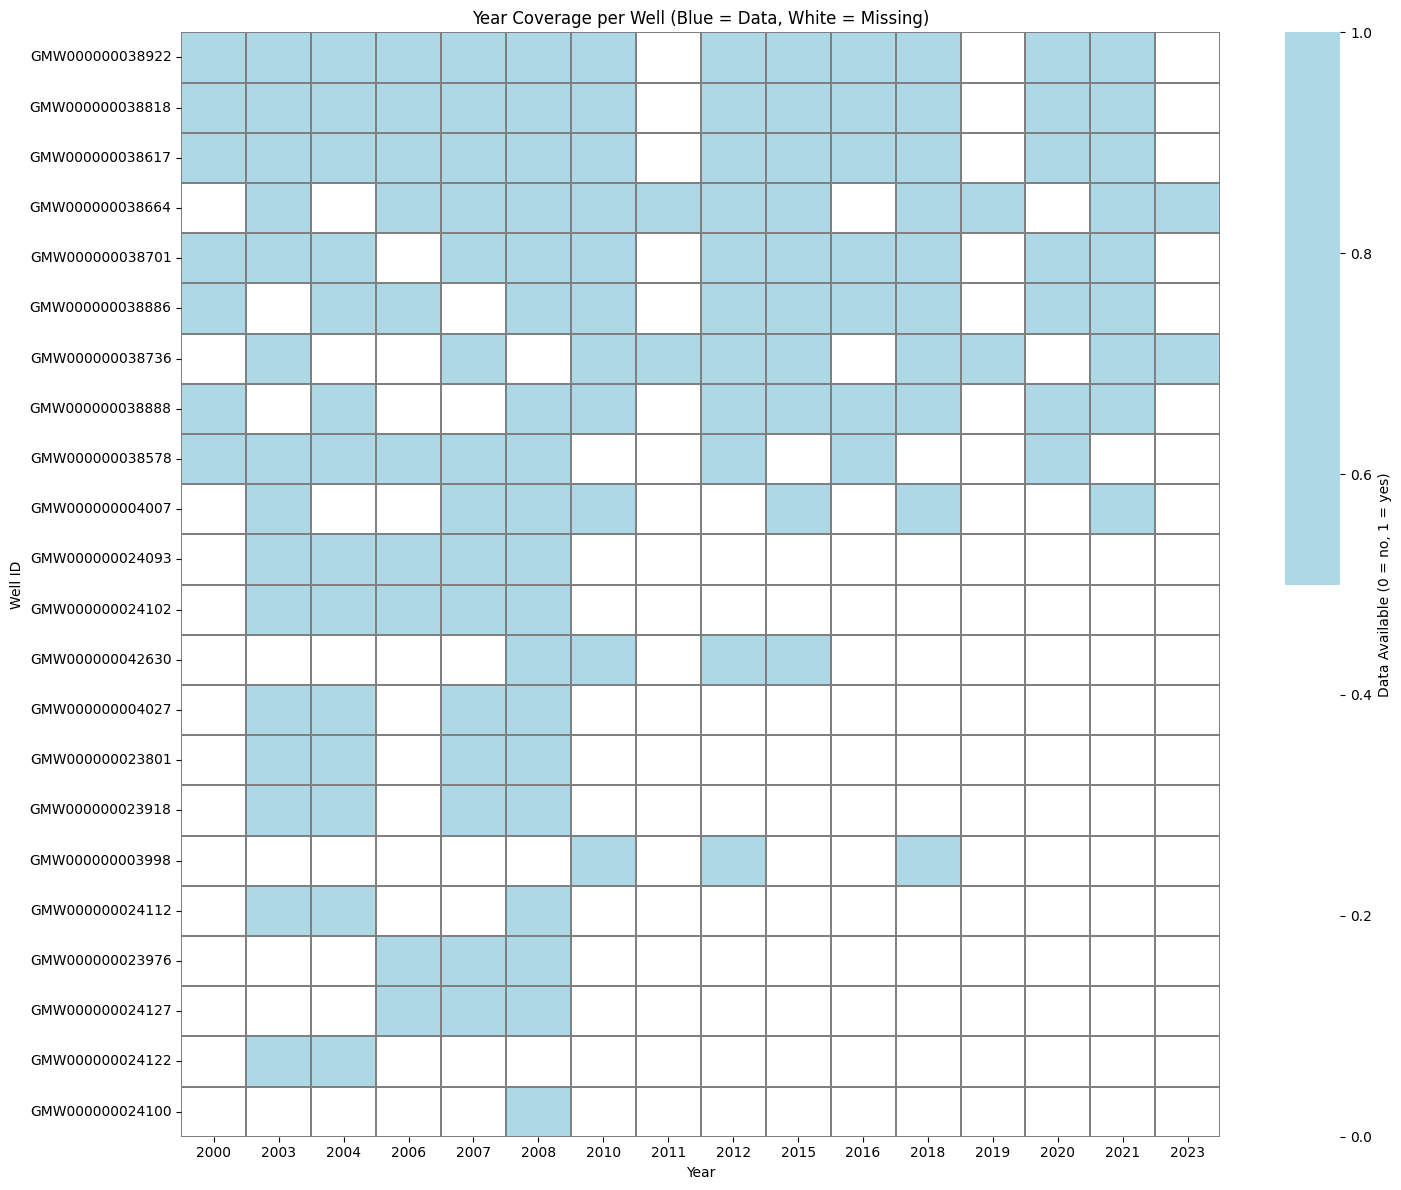

In [35]:
df = df_chem_3.copy()
if "Year" not in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year

# Create binary pivot table: 1 if data exists for that year, else 0
pivot = df.pivot_table(index="Well_ID", columns="Year", values="Nitrate", aggfunc='count', fill_value=0)
pivot = pivot.applymap(lambda x: 1 if x > 0 else 0)

# Sort by number of years with data (descending)
pivot_sorted = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

blue_white_cmap = ListedColormap(["white", "lightblue"])

plt.figure(figsize=(15, 12))
sns.heatmap(
    pivot_sorted, 
    cmap=blue_white_cmap, 
    cbar_kws={'label': 'Data Available (0 = no, 1 = yes)'}, 
    linewidths=0.1, 
    linecolor='gray'
)
plt.title("Year Coverage per Well (Blue = Data, White = Missing)")
plt.xlabel("Year")
plt.ylabel("Well ID")
plt.tight_layout()
plt.show()


In [37]:
df = df_chem_3.copy()
if "Year" not in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year

df_filtered = df[df["Year"] >= 2008]

num_points = len(df_filtered)
print(f"Number of data points with Year >= 2008: {num_points}")

Number of data points with Year >= 2008: 103
